# **Electricity Load Diagrams Clustering Using K-means Algorithm**

## Study the electricity demand from clients in Portugal, during 2013 and 2014.

The data available contains 370 time series, corresponding to the electric demand for 370 clients, between 2011 and 2014.


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed. The data file has been provided with this assignment. It is also available at the links provided above.

In [ ]:
pathToFile = r"Data/"

fileName = 'LD2011_2014.txt'

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [ ]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [ ]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [ ]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [ ]:
data.shape

(140256, 370)

#### As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [ ]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the first 2 days of 2012 for the first 2 clients

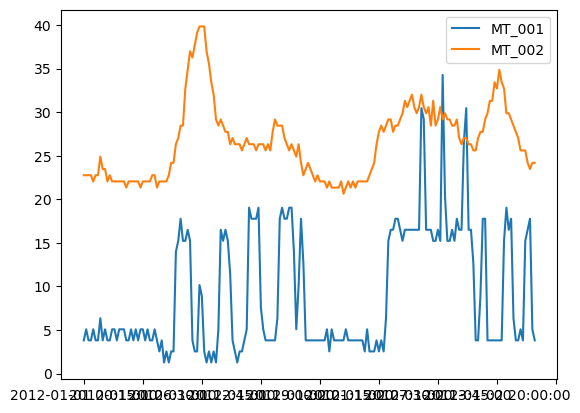

In [ ]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We  note that the main difference between the curves is the level (also seen on the means in df.describe()).  We know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [ ]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [ ]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [ ]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [ ]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013._append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [ ]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [ ]:
data['hour'] = data.index.map(lambda x: x[11:])

In [ ]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [ ]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [ ]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

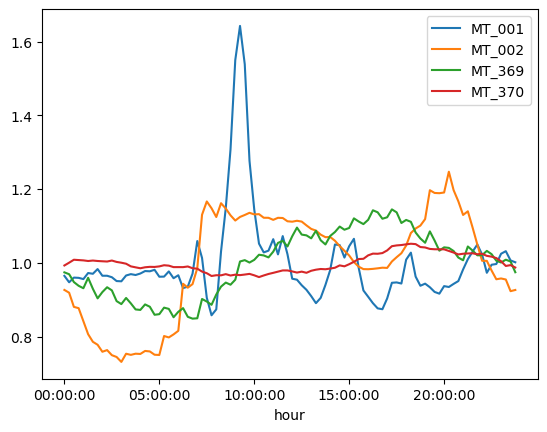

In [ ]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [ ]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format

C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\larry\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\larry\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid

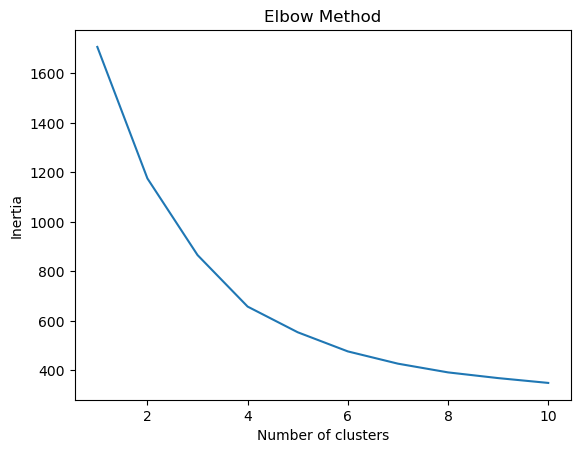

In [ ]:
# Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### Opitmal Clusters: 4

In [ ]:
# Applying K-means with 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [ ]:
# Silhouette Score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.4296355372224769


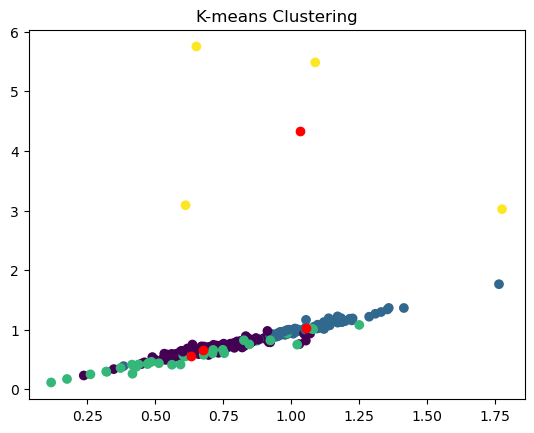

In [ ]:
# Plotting the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centers[:, 0], centers[:, 1], c='red')
plt.title('K-means Clustering')
plt.show()

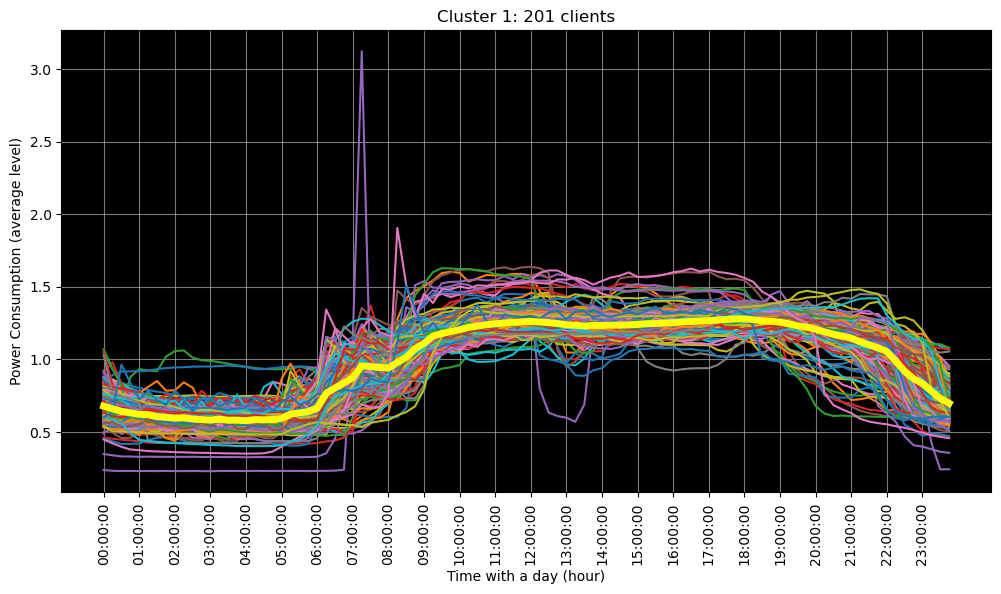

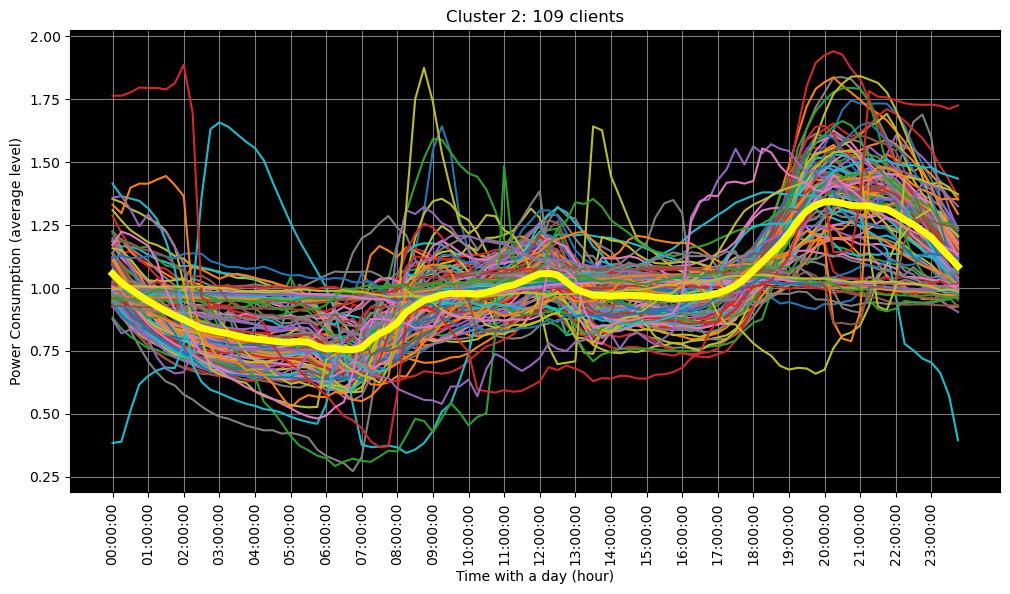

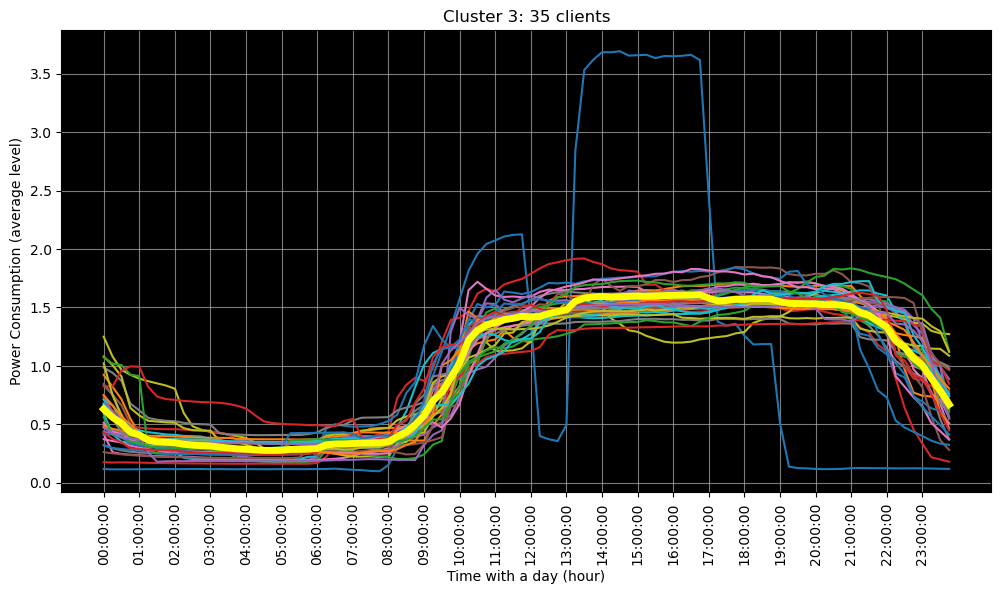

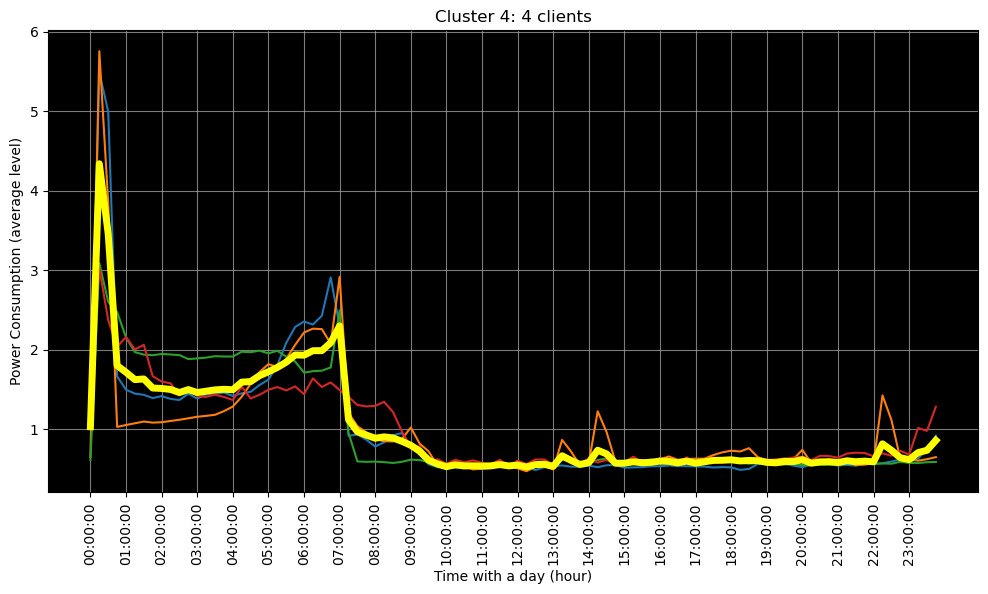

In [ ]:
# Plot each cluster with individual curves and centroids

time_labels = [f'{hour:02d}:{minute:02d}:00' for hour in range(24) for minute in range(0, 60, 15)]

for cluster_num in range(4):
    cluster_indices = np.where(labels == cluster_num)[0]
    plt.figure(figsize=(12, 6))
    plt.title(f'Cluster {cluster_num + 1}: {len(cluster_indices)} clients')

    # Calculate the mean curve for the cluster
    cluster_mean = np.mean(X[cluster_indices], axis = 0)

    # Plot individual client curves
    for idx in cluster_indices:
        plt.plot(X[idx], label=f'Client {idx}')

    # Plot the centroid (center) of the cluster with a thicker line
    plt.gca().set_facecolor('black')
    plt.grid(True, linestyle='-', alpha=0.7)
    plt.plot(cluster_mean, label='Centroid', linewidth=5, linestyle='-', color='yellow')

    plt.xlabel('Time with a day (hour)')
    plt.xticks(range(0, 96, 4), time_labels[::4], rotation=90)
    plt.ylabel('Power Consumption (average level)')
    plt.show()

In [ ]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])])

C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

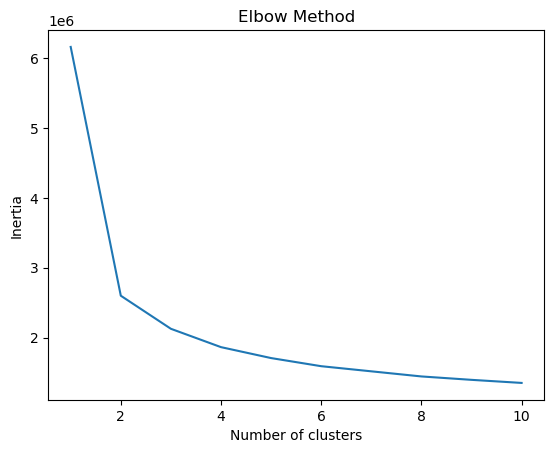

In [ ]:
# Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### Opitmal Clusters: 2

In [ ]:
# Applying K-means with 2 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Silhouette Score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score}")

C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\larry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Silhouette Score: 0.5011374240143707


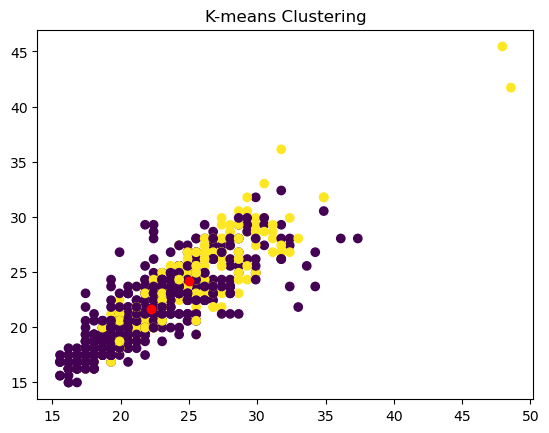

In [ ]:
# Plotting the clusters
X_np = np.array(X)
plt.scatter(X_np[:, 0], X_np[:, 1], c=labels)
plt.scatter(centers[:, 0], centers[:, 1], c='red')
plt.title('K-means Clustering')
plt.show()

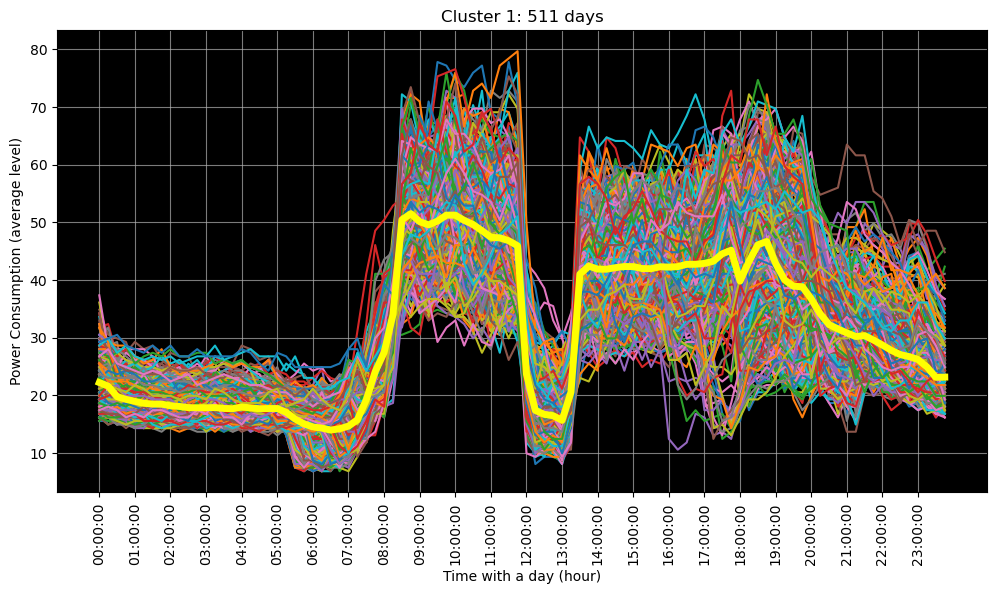

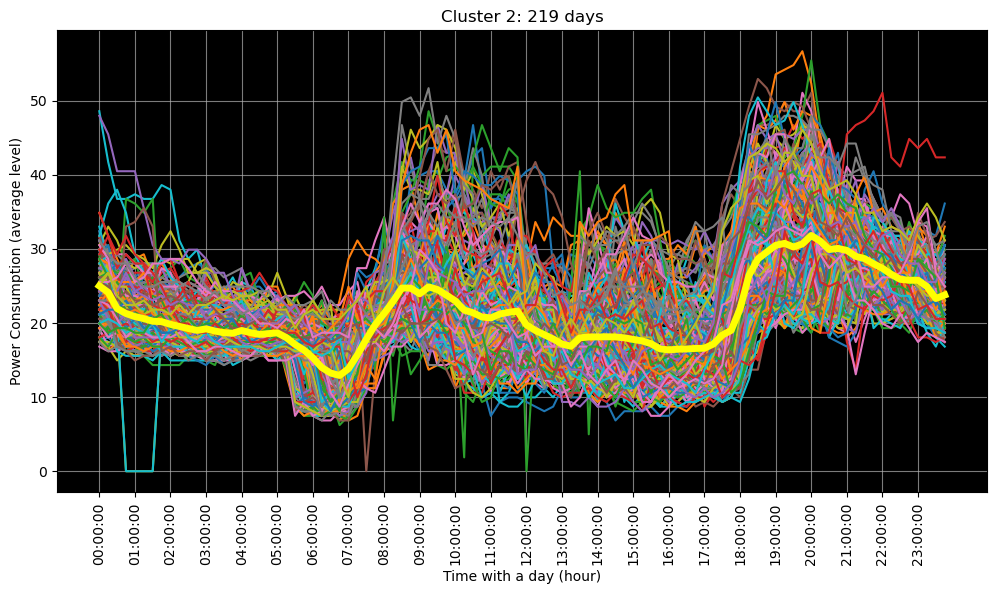

In [ ]:
# Plot each cluster with individual curves and centroids
for cluster_num in range(2):
    cluster_indices = np.where(labels == cluster_num)[0]
    plt.figure(figsize=(12, 6))
    plt.title(f'Cluster {cluster_num + 1}: {len(cluster_indices)} days')

    # Calculate the mean curve for the cluster
    cluster_mean = np.mean(X_np[cluster_indices], axis = 0)

    # Plot individual client curves
    for idx in cluster_indices:
        plt.plot(X_np[idx], label=f'Client {idx}')

    # Plot the centroid (center) of the cluster with a thicker line
    plt.gca().set_facecolor('black')
    plt.grid(True, linestyle='-', alpha=0.7)
    plt.plot(cluster_mean, label='Centroid', linewidth=5, linestyle='-', color='yellow')

    plt.xlabel('Time with a day (hour)')
    plt.xticks(range(0, 96, 4), time_labels[::4], rotation=90)
    plt.ylabel('Power Consumption (average level)')
    plt.show()

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b).  The cells below are only to give you a headstart.  You may or may not use these and come up with your own interpretation.


In [ ]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [ ]:
#from itertools import compress
#L = [1,2,3,4]
#B = [False, True, True, False]
#list(compress(L, B))

In [ ]:
from itertools import compress

cluster_1_weekdays = 0
cluster_2_weekdays = 0
c1_total_days = 0
c2_total_days = 0

for i, label in enumerate(labels):
    if label == 0:  # Cluster 1
        day = daysyear[i].split('-')[0]  # Extract the day of the week
        if day in ['mon', 'tue', 'wed', 'thu', 'fri']:
            cluster_1_weekdays += 1
        c1_total_days += 1
    elif label == 1:  # Cluster 2
        day = daysyear[i].split('-')[0]  # Extract the day of the week
        if day in ['mon', 'tue', 'wed', 'thu', 'fri']:
            cluster_2_weekdays += 1
        c2_total_days += 1

cluster_1_weekday_percentage = round(cluster_1_weekdays / c1_total_days,2) * 100
cluster_2_weekday_percentage = round(cluster_2_weekdays / c2_total_days,2) * 100

print("Total Days in Cluster 1:", c1_total_days, "days")
print("Weekdays in Cluster 1:", cluster_1_weekdays, "days")
print("Percentage of Weekdays in Cluster 1:", int(cluster_1_weekday_percentage), "%")
print("\n")
print("Total Days in Cluster 2:", c2_total_days, "days")
print("Weekdays in Cluster 2:", cluster_2_weekdays, "days")
print("Percentage of Weekdays in Cluster 2:", int(cluster_2_weekday_percentage), "%")

Total Days in Cluster 1: 511 days
Weekdays in Cluster 1: 465 days
Percentage of Weekdays in Cluster 1: 91 %


Total Days in Cluster 2: 219 days
Weekdays in Cluster 2: 57 days
Percentage of Weekdays in Cluster 2: 26 %


**Summary**
 - The optimal cluster is 2 based on the elbow method.
 - The Silhouette Score 0.50 revealed that the data points tend to be well-matched to their assigned clusters, and the highest Silhouette Score was achieved for 2 clusters.
 - Examining the two clusters, it's apparent that our client, MT_022, exhibits two distinct electricity usage patterns. One hypothesis emerges: the client may work from home, indicated by the consistent pattern in Cluster 1. Further analysis will help confirm this.


Upon analyzing client MT_022's electricity consumption, two distinct clusters emerged: Cluster 1, comprising 91% of the data, represents typical workdays, characterized by a stable usage pattern from 8 am to 6 pm, while Cluster 2, representing weekends and off-days, displays a different consumption behavior. This suggests that the client likely works from home during weekdays, with a routine that includes waking up at 7 am, working during the day, and gradual electricity reduction until midnight.

### Client Analysis: MT_022

### Cluster Analysis:
 - Elbow method suggests 2 clusters.
 - Silhouette Score of 0.50 indicates distinct clusters.

#### Cluster 1 (Likely Workdays):
 - Total days: 511
 - Weekdays (Mon-Fri): 465 (91%)
 - Typical workday pattern.

#### Cluster 2 (Likely Weekends/Off Days):
 - Total days: 219
 - Weekdays (Mon-Fri): 57 (26%)
 - Different usage pattern.

#### Workday Daily Patterns:
 - Wake up at 7 am, work from 8 am to 12 pm.
 - Rest until 1 pm, with possible work until 6 pm.
 - Gradual electricity decrease until around 12 am.

#### Conclusion:
Client MT_022 likely works from home on weekdays based on distinct electricity consumption patterns. Weekends show different usage behavior.